# Initialize Environment

In [14]:
import matplotlib, matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
from scipy.stats import norm
from scipy.io import loadmat
import glob
import pandas as pd
import datetime
import pandas_datareader.tsp as tsp
import pandas_datareader.data as pdr
import requests_cache
import yfinance as yf
yf.pdr_override() # https://pypi.org/project/yfinance/

from copy import deepcopy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Seed Random number generator for repeatability
np.random.seed(19690720)

plt.style.use('default')
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams.update({'font.size': 18})

# Load Data
## Data Caches

In [15]:
session = requests_cache.CachedSession(cache_name='cache', 
                                       backend='sqlite', 
                                       expire_after=datetime.timedelta(hours=8))

## Vanguard

In [16]:
tickers = [ 'VTSAX', 'VSGAX', 'VGSLX', 'VHYAX', 'VTCLX', 'VTMFX', 'VBTLX' ]

data = pdr.get_data_yahoo(
        # tickers list or string as well
        tickers = tickers,

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "5y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = False,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None,
    
        # session cache
        session = session
    )

[*********************100%***********************]  7 of 7 completed


## TSP
Load TSP data using the pandas_datareader utility. Allow for 8-hour persistent caching. 

In [18]:
tspreader = tsp.TSPReader(session=session)
tspdata = tspreader.read()

print(type(tspdata), tspdata)
# write the data, in reversed order
#tspdata.iloc[::-1].to_csv('~/Downloads/tsp_shareprices.csv')
tspdata.iloc[::-1].to_excel('tsp_shareprices.xls', sheet_name='TSP Data')

<class 'pandas.core.frame.DataFrame'>             L Income   L 2020   L 2030   L 2040   L 2050   G Fund   F Fund  \
date                                                                         
2015-05-04   17.7281  23.6224  25.7687  27.5247  15.6904  14.7103  16.9570   
2015-05-05   17.6884  23.4941  25.5860  27.2975  15.5452  14.7111  16.9272   
2015-05-06   17.6835  23.4882  25.5790  27.2897  15.5427  14.7119  16.8826   
2015-05-07   17.6902  23.4958  25.5906  27.3067  15.5503  14.7127  16.9248   
2015-05-08   17.7414  23.6622  25.8216  27.5863  15.7307  14.7135  16.9603   
...              ...      ...      ...      ...      ...      ...      ...   
2020-04-24   20.5719  28.2665  31.5565  34.0366  19.5223  16.4252  20.6993   
2020-04-27   20.6522  28.3845  31.9059  34.4903  19.8222  16.4264  20.6374   
2020-04-28   20.6644  28.4023  31.9521  34.5510  19.8631  16.4267  20.6880   
2020-04-29   20.7858  28.5804  32.4731  35.2262  20.3079  16.4271  20.6888   
2020-04-30   20.7296  28.4

# Derived Data

In [19]:
print(data)
ddata = data.swaplevel(0,1,axis=1).drop(['Open', 'High', 'Low', 'Volume'], axis=1)['Close']
#print(type(data), data.columns, ddata.columns)

#print(type(tspdata), tspdata, tspdata.columns)

                VHYAX                                              VBTLX  \
                 Open       High        Low      Close Volume       Open   
Date                                                                       
2015-05-01        NaN        NaN        NaN        NaN    NaN   9.551869   
2015-05-04        NaN        NaN        NaN        NaN    NaN   9.534308   
2015-05-05        NaN        NaN        NaN        NaN    NaN   9.525527   
2015-05-06        NaN        NaN        NaN        NaN    NaN   9.499195   
2015-05-07        NaN        NaN        NaN        NaN    NaN   9.516747   
...               ...        ...        ...        ...    ...        ...   
2020-04-24  23.110001  23.110001  23.110001  23.110001    0.0  11.540000   
2020-04-27  23.549999  23.549999  23.549999  23.549999    0.0  11.490000   
2020-04-28  23.629999  23.629999  23.629999  23.629999    0.0  11.520000   
2020-04-29  24.040001  24.040001  24.040001  24.040001    0.0  11.530000   
2020-04-30  

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


# Plot Data
## Vanguard

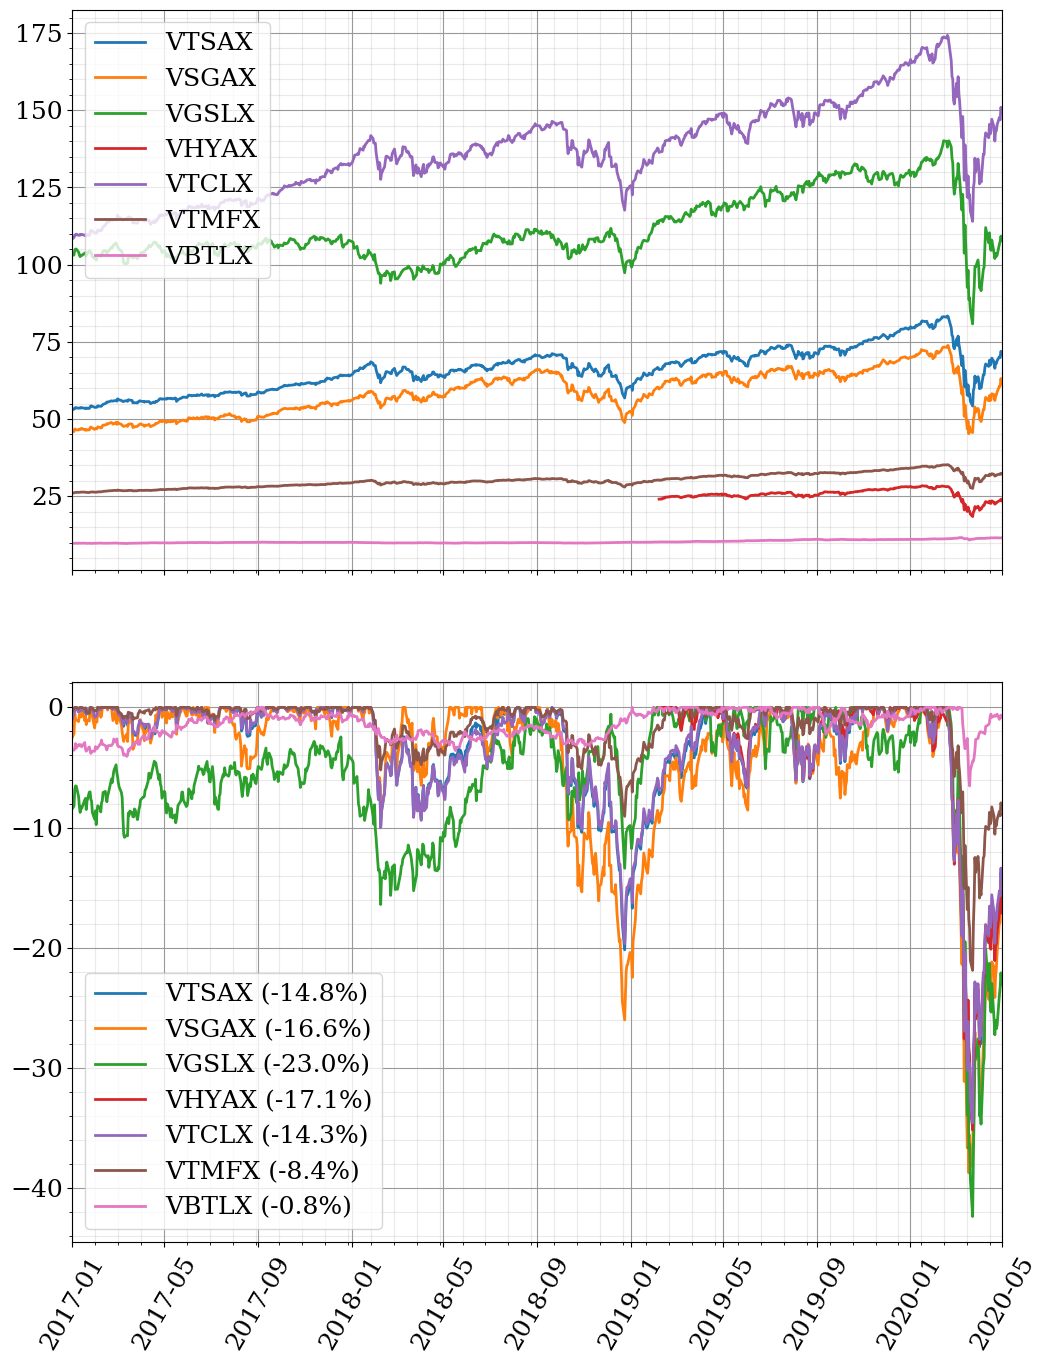

In [20]:
# Compute the drawdown of an array, in place.
def drawdown (array):
    dd=deepcopy(array)
    maxval=-1
    for i in range(len(dd)):
        idx = i
        if array[idx] > maxval: maxval = array[idx]
        dd[idx] = (array[idx]/maxval - 1.) * 100.
    return dd

# Plot the prices & drawdowns over/under
def plot_prices_dd(tickers, data, ax):
    for t in tickers:
        #print(t, data[t].columns)
        #print(t, data[t])
        close = data[t]['Close']
        #print(type(close.index), type(close.values))
        dd = drawdown(close.values)

        ax[0].plot(close.index, close.values, label=t, linewidth=2.0)
        ax[0].grid(b=True, which='major', color='#999999', linestyle='-')
        ax[0].minorticks_on()
        ax[0].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        ax[0].legend(fancybox=True, loc=2)

        ax[1].plot(close.index, dd, label='{} ({:.1f}%)'.format(t,dd[-1]), linewidth=2.0)
        ax[1].grid(b=True, which='major', color='#999999', linestyle='-')
        ax[1].minorticks_on()
        ax[1].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        ax[1].legend(fancybox=True, loc=3)
        ax[1].set_xlim([datetime.date(2017, 1, 1), datetime.date.today()])
        plt.xticks(rotation=60)
    return



###########################################    
fig, ax  = plt.subplots(nrows=2, ncols=1,
                        sharex=True, sharey=False,
                        figsize=(12,8*2))

plot_prices_dd(tickers, data, ax)



#plt.show()
fig.savefig('vg_shareprices.pdf', bbox_inches='tight')

## TSP

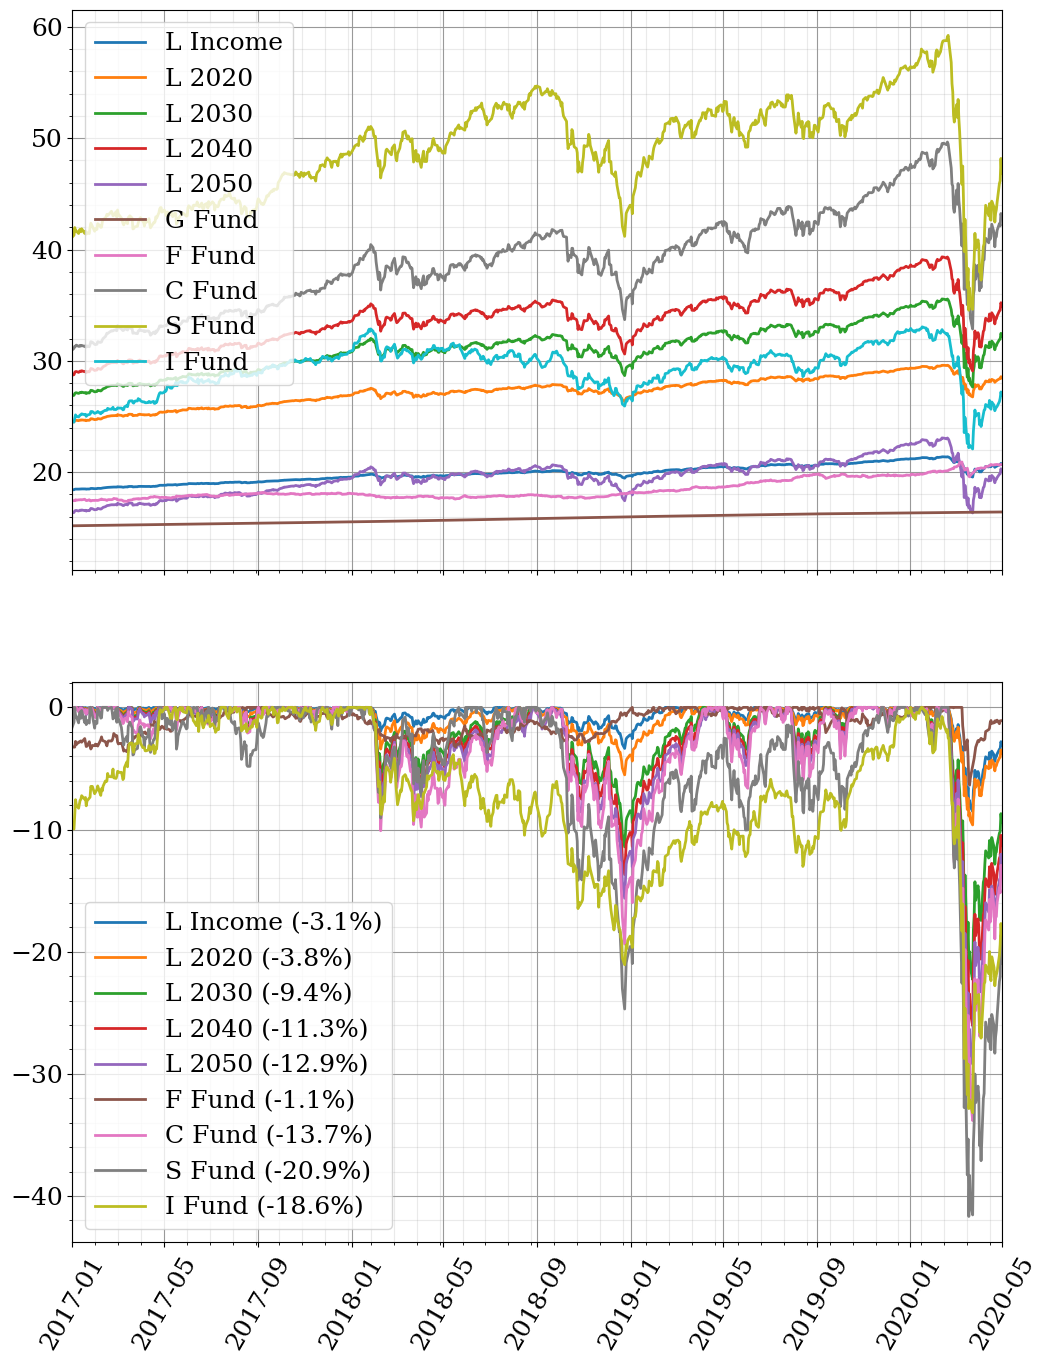

In [21]:
# Plot the prices & drawdowns over/under
def plot_tsp_prices_dd(tspdata, ax):
    for c in tspdata.columns:
        if not c: continue
        close = tspdata[c]
        #print(type(close.index), type(close.values))
        #print(close)
        dd = drawdown(close.values)

        ax[0].plot(close.index, close.values, label=c, linewidth=2.0)
        ax[0].grid(b=True, which='major', color='#999999', linestyle='-')
        ax[0].minorticks_on()
        ax[0].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        ax[0].legend(fancybox=True, loc=2)

        if 'G Fund' in c: continue
        ax[1].plot(close.index, dd, label='{} ({:.1f}%)'.format(c,dd[-1]), linewidth=2.0)
        ax[1].grid(b=True, which='major', color='#999999', linestyle='-')
        ax[1].minorticks_on()
        ax[1].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        ax[1].legend(fancybox=True, loc=3)
        ax[1].set_xlim([datetime.date(2017, 1, 1), datetime.date.today()])
        plt.xticks(rotation=60)
    return



###########################################    
fig, ax  = plt.subplots(nrows=2, ncols=1,
                        sharex=True, sharey=False,
                        figsize=(12,8*2))

plot_tsp_prices_dd(tspdata, ax)
fig.savefig('tsp_shareprices.pdf', bbox_inches='tight')

# Correlations
## Vanguard

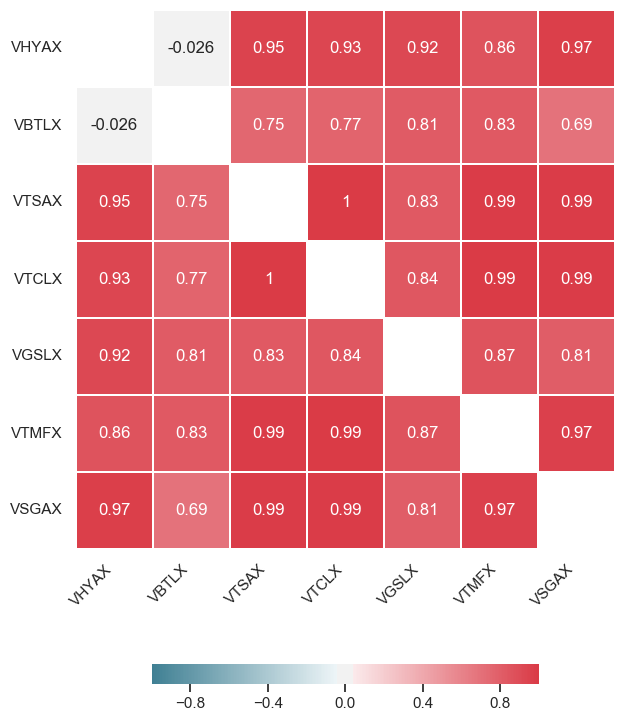

In [22]:
import seaborn as sns

sns.set(style="white")

corr = ddata.corr()

# Generate a mask for the upper triangle or diagonal
#mask = np.triu(np.ones_like(corr, dtype=np.bool))
mask = np.eye(len(corr))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, center=0, vmin=-1, vmax=1, cmap=cmap, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5, "orientation": "horizontal"})

ax.set_xlabel(None)
ax.set_ylabel(None)
#ax.set_yticklabels([ item.get_text().strip('Close-') for item in ax.get_yticklabels() ])
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    verticalalignment='center')
ax.set_xticklabels(
    ax.get_yticklabels(),
    rotation=45,
    horizontalalignment='right')
(bottom, top) = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
f.savefig('vg_correlation.pdf', bbox_inches='tight')

## TSP

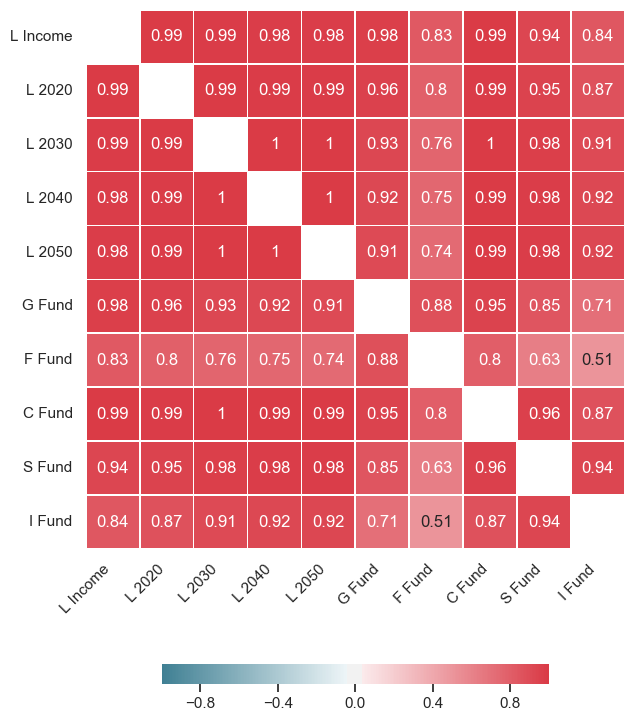

In [23]:
corr = tspdata.corr()

# Generate a mask for the upper triangle or diagonal
#mask = np.triu(np.ones_like(corr, dtype=np.bool))
mask = np.eye(len(corr))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, center=0., vmin=-1, vmax=1, cmap=cmap, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5, "orientation": "horizontal"})


ax.set_xlabel(None)
ax.set_ylabel(None)
#ax.set_yticklabels([ item.get_text().strip('Close-') for item in ax.get_yticklabels() ])
ax.set_yticklabels(
    ax.get_yticklabels(),
    verticalalignment='center')
ax.set_xticklabels(
    ax.get_yticklabels(),
    rotation=45,
    horizontalalignment='right')
(bottom, top) = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
f.savefig('tsp_correlation.pdf', bbox_inches='tight')